<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Regression-based Rating Score Prediction using Embedding Features**


Estimated time needed: **45** minutes


In our previous lab, you have trained a neural network to predict the user-item interactions while simultaneously extracting the user and item embedding features. In the neural network, extends this by using  two embedding vectors as an input into a Neural Network to predict the rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/rating_regression.png)



Another way to make rating predictions is to use the embedding as an input to a neural network by aggregating them into a single feature vector as input data `X`. 

With the interaction label `Y` such as a rating score or an enrollment mode, we can build our other standalone predictive models to approximate the mapping from `X` to `Y`, as shown in the above flowchart.


In this lab, you will be given the course interaction feature vectors as input data `X` and consider label `Y` as the numerical rating scores. As such, we turn the recommender system into a common regression task and you can apply what you have learned about regression modeling to predict the ratings.


## Objectives


After completing this lab you will be able to:


* Build regression models to predict ratings using the combined embedding vectors


----


## Prepare and setup lab environment


First install and import required libraries:


In [1]:
#!pip install scikit-learn==1.0.2

In [2]:
# also set a random state
rs = 123

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


### Load datasets


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
rating_url = "nice_data.csv"
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

The first dataset is the rating dataset that contains a user-item interaction matrix


In [5]:
rating_df = pd.read_csv(rating_url)

In [6]:
rating_df["rating"][ rating_df["rating"] < 1  ] = 0
rating_df["rating"][ rating_df["rating"]  > 1 ] = 3
rating_df.head()

/tmp/ipykernel_13007/379530695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["rating"][ rating_df["rating"] < 1  ] = 0
/tmp/ipykernel_13007/379530695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["rating"][ rating_df["rating"]  > 1 ] = 3


,user,item,rating
0,2,BD0221EN,3.0
1,2,LB0107ENv1,3.0
2,2,SC0105EN,3.0
3,2,CO0201EN,0.0
4,2,BD0123EN,3.0


As you can see from the above data, the user and item are just ids, let's substitute them by their embedding vectors:


In [7]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

In [8]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


In [9]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [10]:
# Merge user embedding features
user_emb_merged = pd.merge(rating_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [11]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,2,BD0221EN,3.0,0.02163,0.025561,-0.116771,-0.026099,0.08159,0.118796,-0.110325,...,0.001127,-0.042721,-0.020004,-0.004160,-0.022699,-0.054916,-0.011230,-0.037942,-0.016477,0.016040
1,2,LB0107ENv1,3.0,0.02163,0.025561,-0.116771,-0.026099,0.08159,0.118796,-0.110325,...,0.026085,0.023909,-0.015020,0.018504,-0.033117,0.041930,-0.026071,0.011439,0.015818,-0.013199
2,2,SC0105EN,3.0,0.02163,0.025561,-0.116771,-0.026099,0.08159,0.118796,-0.110325,...,0.024451,-0.021855,0.076256,-0.004345,-0.012459,-0.015200,0.016222,0.002568,0.004560,0.035618
3,2,CO0201EN,0.0,0.02163,0.025561,-0.116771,-0.026099,0.08159,0.118796,-0.110325,...,-0.003080,0.023442,-0.018411,0.005600,-0.018589,-0.007688,-0.012450,-0.033382,0.017794,-0.000448
4,2,BD0123EN,3.0,0.02163,0.025561,-0.116771,-0.026099,0.08159,0.118796,-0.110325,...,0.006007,0.006638,-0.002519,0.016422,-0.054736,0.015872,0.015215,-0.012534,-0.009105,-0.017294


Next, we can combine the user features (the column labels starting with `UFeature` and item features (the column labels starting with `CFeature`. In machine learning, there are many ways to aggregate two feature vectors such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:


In [12]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
regression_dataset['rating'] = ratings
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.036741,-0.018893,-0.108316,-0.035448,0.116518,0.137294,-0.109198,0.030428,0.036904,0.002666,0.026241,-0.109469,-0.027370,-0.095184,0.005960,0.026962,3.0
1,0.064088,0.003396,-0.095919,-0.033637,0.098566,0.118971,-0.084239,0.097058,0.041888,0.025329,0.015823,-0.012622,-0.042212,-0.045803,0.038255,-0.002277,3.0
2,-0.026352,-0.004874,-0.118413,-0.007490,0.069347,0.099571,-0.085874,0.051294,0.133164,0.002481,0.036481,-0.069753,0.000082,-0.054675,0.026997,0.046540,3.0
3,-0.011094,0.031639,-0.124576,-0.016366,0.077938,0.092492,-0.113405,0.096591,0.038497,0.012425,0.030351,-0.062240,-0.028590,-0.090624,0.040231,0.010474,0.0
4,0.044412,0.017202,-0.119051,0.001207,0.084862,0.118005,-0.104318,0.079788,0.054389,0.023247,-0.005796,-0.038680,-0.000925,-0.069776,0.013332,-0.006372,3.0


By now, we have built the input dataset `X` and the output vector `y`:


In [13]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (533306, 16), Output data shape: (533306,)


## TASK: Perform regression on the interaction dataset


Now our input data `X` and output `y` are ready, let's build regression models to map X to y and predict ratings. 


y.unique()


In an online course system, we may consider the `Completion` mode to be `larger` than the `Audit` mode as a learner needs to put more efforts towards completion.  Now if we treat it as a regression problem,  we would expect the regression model to output ratings ranging from 2.0 to 3.0. To interpret regression model output, we can treat values closer to 2.0 as `Audit` and values closer to 3.0 as `Completion`.


You may use `sklearn` to train and evaluate various regression models.


_TODO: First split dataset into training and testing datasets_


In [14]:
### WRITE YOUR CODE HERE
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler
#X,y = scaler.fit_transform(X,y)
#y = y -2

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=rs,test_size=0.3)

In [15]:
X_train

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15
65010,-0.118880,0.046728,-0.024099,0.025745,-0.193203,-0.052563,0.166041,-0.026698,0.112355,-0.034464,-0.055767,0.042456,-0.057810,-0.094324,-0.075398,-0.016729
143936,0.073101,-0.035611,0.025036,-0.010194,-0.002501,-0.012629,-0.012978,0.017372,-0.028085,-0.016034,0.003510,-0.056649,-0.110540,0.038352,0.074827,0.090402
205146,0.001431,-0.040176,0.059490,0.085392,-0.069032,0.000812,-0.096224,0.087309,-0.019588,-0.124708,0.060001,-0.034599,0.132744,-0.080391,0.001747,-0.006544
235580,-0.031680,0.059656,-0.081405,0.003343,-0.095556,0.009286,0.006857,-0.011679,-0.114557,-0.070335,-0.032494,0.009077,-0.041334,0.020210,0.032645,-0.007912
48663,-0.040264,-0.018912,0.011216,-0.035603,0.004063,-0.024140,0.021831,-0.018600,-0.013566,0.023126,0.011194,0.021963,-0.012266,0.043907,-0.025385,-0.042042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194278,0.139943,-0.033335,0.107798,-0.058226,-0.048590,0.056476,0.016326,-0.099744,0.091285,0.138433,0.087377,-0.013914,-0.015517,0.144343,0.069960,0.034230
192476,-0.055732,0.065079,0.035236,-0.139196,-0.011074,-0.091777,-0.056550,-0.126191,0.065220,0.009116,-0.140614,0.052917,-0.030680,-0.219090,0.028691,0.081419
17730,0.056187,0.139169,0.041578,-0.069070,0.051675,0.117964,-0.099858,-0.026426,0.028939,0.099553,0.050393,-0.036436,0.066613,-0.035880,0.054076,0.122035
28030,-0.079685,0.078756,-0.076372,-0.059959,0.065124,0.027254,-0.035619,0.049043,-0.002678,-0.138924,-0.087857,0.121203,0.101312,0.058056,0.068503,0.182239


In [16]:
sum( y_test == 2 ) , sum( y_test == 3 )

(0, 69928)

<details>
    <summary>Click here for Hints</summary>
    
Use `train_test_split()` to split dataset into training and testing datasets.  Use `X, y` as input dataset and output vector. Don't forget to specify `random_state = rs` and `test_size=0.3`.


_TODO: Create a basic linear regression model_


In [17]:
### WRITE YOUR CODE HERE
model = linear_model.Ridge(alpha=0.2)

<details>
    <summary>Click here for Hints</summary>
    
You can call `linear_model.Ridge()` method and specify `alpha=0.2` ( it's controlling regularization) in the parameters.


_TODO: Train the basic regression model with training data_


In [18]:
### WRITE YOUR CODE HERE
model.fit(X_train, y_train)

Ridge(alpha=0.2)

<details>
    <summary>Click here for Hints</summary>
    
You can call `model.fit()` method with `X_train, y_train` parameters.


_TODO: Evaluate the basic regression model_


In [19]:
### WRITE YOUR CODE HERE

### The main evaluation metric is RMSE but you may use other metrics as well

y_predict = model.predict(X_test)

mean_squared_error(y_test,  y_predict, squared=False), y_predict.shape

(1.482707689109729, (159992,))

In [20]:
min(y_train), max(y_train), min(y_predict), max(y_predict)

(0.0, 3.0, 0.5162227140162233, 1.9623341735616922)

0.0 3.0 0.5161258945121845 1.9624109369233427
0.0 1.4827077613076245
0.0 3.0 0.5163678986881792 1.9622190628877432
0.5 1.4827075811635988
0.0 3.0 0.5166097543242085 1.9620273033586444
1.0 1.4827074021875415
0.0 3.0 0.5168514615583646 1.9618356582325256
1.5 1.4827072243774377
0.0 3.0 0.5170930205285666 1.9616441274059935
2.0 1.482707047731276
0.0 3.0 0.5173344313725614 1.9614527107757798
2.5 1.4827068722470491
0.0 3.0 0.5175756942279239 1.9612614082387423
3.0 1.4827066979227537
0.0 3.0 0.5178168092320565 1.9610702196918641
3.5 1.482706524756389
0.0 3.0 0.5180577765221906 1.9608791450322534
4.0 1.4827063527459585
0.0 3.0 0.5182985962353858 1.960688184157143
4.5 1.4827061818894687
0.0 3.0 0.5185392685085313 1.9604973369638923
5.0 1.4827060121849305
0.0 3.0 0.5187797934783441 1.960306603349983
5.5 1.4827058436303577
0.0 3.0 0.5190201712813725 1.9601159832130228
6.0 1.482705676223768
0.0 3.0 0.519260402053993 1.9599254764507423
6.5 1.4827055099631825
0.0 3.0 0.5195004859324133 1.95973508296

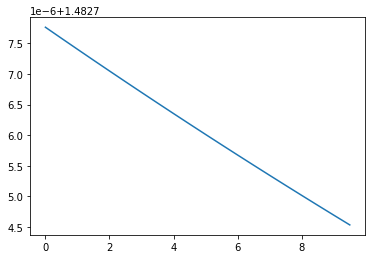

In [21]:
rmses = []
alphas = np.arange( 0,10,0.5 )
for alpha in alphas:
    model = linear_model.Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print( min(y_train), max(y_train), min(y_predict), max(y_predict) )
    rmse = mean_squared_error(y_test,  y_predict, squared=False)
    print(alpha,rmse)
    rmses.append( rmse )
    
plt.plot( alphas, rmses )

<details>
    <summary>Click here for Hints</summary>
    
You can call `model.predict()` method with `X_test` parameter to get model predictions. Then use `mean_squared_error()` with `y_test, your_predictions` parameters to calculate the RMSE. 


_TODO: Try different regression models such as Ridge, Lasso, ElasticNet and tune their hyperparameters to see which one has the best performance_


0.0 3.0 1.3129269194297561 1.3129269194297561
0.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
0.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
1.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
1.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
2.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
2.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
3.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
3.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
4.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
4.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
5.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
5.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
6.01 1.488073709281931
0.0 3.0 1.3129269194297561 1.3129269194297561
6.51 1.488073709281931
0.0 3.0 1.3129269194297561 1.31292

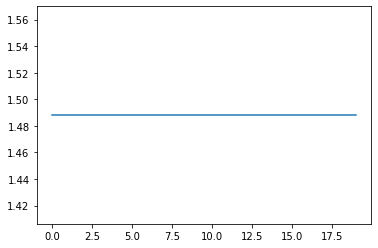

In [22]:
### WRITE YOUR CODE HERE
rmses = []
alphas = np.arange( 0.01,10,0.5 )
for alpha in alphas:
    model = linear_model.Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print( min(y_train), max(y_train), min(y_predict), max(y_predict) )
    rmse = mean_squared_error(y_test,  y_predict, squared=False)
    print(alpha,rmse)
    rmses.append( rmse )
    
plt.plot( rmses )

In [23]:
min(y_predict), max(y_predict)

(1.3129269194297561, 1.3129269194297561)

0.0 3.0 0.5161289534755575 1.9624091323659099
1e-08 1.4827077595010645
0.0 3.0 0.516431792192892 1.962230468838474
1e-06 1.4827075810877428
0.0 3.0 0.5463760091345209 1.944559542973439
0.0001 1.4826957847077729
0.0 3.0 1.312305613166622 1.3135640712790924
0.01 1.4880674062316315
0.0 3.0 1.3129269194297561 1.3129269194297561
0.1 1.488073709281931


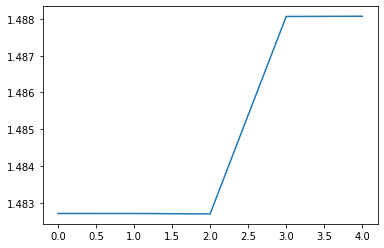

In [24]:
### WRITE YOUR CODE HERE
rmses = []
alphas = [ 0.00000001, 0.000001, 0.0001,0.01,0.1]
for alpha in alphas:
    model = linear_model.ElasticNet(alpha=alpha)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print( min(y_train), max(y_train), min(y_predict), max(y_predict) )
    rmse = mean_squared_error(y_test,  y_predict, squared=False)
    print(alpha,rmse)
    rmses.append( rmse )
    
plt.plot( rmses )

### Summary


In this lab, you have built regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks. In the next lab, we can treat the prediction problem as a classification problem as rating only has two categorical values so classification can be a more natural problem statement.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01)


### Other Contributors


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-10-25|1.0|Yan|Created the initial version|


Copyright © 2021 IBM Corporation. All rights reserved.
